In [1]:
%matplotlib inline

## Signal control by PyTorch (DQN)

In this notebook, we present coordinated traffic signal control by deep reinforcement learning by directly integrating UXsim with PyTorch.

In [2]:
from uxsim import *
import pandas as pd
import itertools

### Without control

First, let's simulate arterial network with 4 intersections.
The shape of the network is as follows.

```
    N1  N2
    |   |
W1--I1--I2--E1
    |   |
W2--I3--I4--E2
    |   |
    S1  S2
```

In [3]:
# world definition
seed = None
W = World(
    name="",
    deltan=5,
    tmax=3600,
    print_mode=1, save_mode=0, show_mode=1,
    random_seed=seed,
    duo_update_time=600
)
random.seed(seed)

# network definition
"""
    N1  N2
    |   |
W1--I1--I2--E1
    |   |
W2--I3--I4--E2
    |   |
    S1  S2
"""

I1 = W.addNode("I1", 0, 0, signal=[60,60])
I2 = W.addNode("I2", 1, 0, signal=[60,60])
I3 = W.addNode("I3", 0, -1, signal=[60,60])
I4 = W.addNode("I4", 1, -1, signal=[60,60])
W1 = W.addNode("W1", -1, 0)
W2 = W.addNode("W2", -1, -1)
E1 = W.addNode("E1", 2, 0)
E2 = W.addNode("E2", 2, -1)
N1 = W.addNode("N1", 0, 1)
N2 = W.addNode("N2", 1, 1)
S1 = W.addNode("S1", 0, -2)
S2 = W.addNode("S2", 1, -2)
#E <-> W direction: signal group 0
for n1,n2 in [[W1, I1], [I1, I2], [I2, E1], [W2, I3], [I3, I4], [I4, E2]]:
    W.addLink(n1.name+n2.name, n1, n2, length=500, free_flow_speed=10, jam_density=0.2, signal_group=0)
    W.addLink(n2.name+n1.name, n2, n1, length=500, free_flow_speed=10, jam_density=0.2, signal_group=0)
#N <-> S direction: signal group 1
for n1,n2 in [[N1, I1], [I1, I3], [I3, S1], [N2, I2], [I2, I4], [I4, S2]]:
    W.addLink(n1.name+n2.name, n1, n2, length=500, free_flow_speed=10, jam_density=0.2, signal_group=1)
    W.addLink(n2.name+n1.name, n2, n1, length=500, free_flow_speed=10, jam_density=0.2, signal_group=1)

# random demand definition
dt = 30
demand = 0.22
for n1, n2 in itertools.permutations([W1, W2, E1, E2, N1, N2, S1, S2], 2):
    for t in range(0, 3600, dt):
        W.adddemand(n1, n2, t, t+dt, random.uniform(0, demand))

Each signal has 2 phases: greenlight for E-W direction and that for N-S. The demand is randomly given, and its mean is evenly distribuded from each boundary node to every others. Because of this even distribution, each green split (duration) is set as the same: 60 seconds. 

simulation setting:
 scenario name: 
 simulation duration:	 3600 s
 number of vehicles:	 8340 veh
 total road length:	 12000 m
 time discret. width:	 5 s
 platoon size:		 5 veh
 number of timesteps:	 720
 number of platoons:	 1668
 number of links:	 24
 number of nodes:	 12
 setup time:		 0.04 s
simulating...
      time| # of vehicles| ave speed| computation time
       0 s|        0 vehs|   0.0 m/s|     0.00 s
     600 s|      575 vehs|   5.3 m/s|     0.28 s
    1200 s|      755 vehs|   3.7 m/s|     0.58 s
    1800 s|     1050 vehs|   1.7 m/s|     0.85 s
    2400 s|     1275 vehs|   1.8 m/s|     1.10 s
    3000 s|     1280 vehs|   1.7 m/s|     1.36 s
    3595 s|     1315 vehs|   1.6 m/s|     1.59 s
 simulation finished
results:
 average speed:	 2.8 m/s
 number of completed trips:	 5260 / 8340
 average travel time of trips:	 566.6 s
 average delay of trips:	 411.8 s
 delay ratio:			 0.727


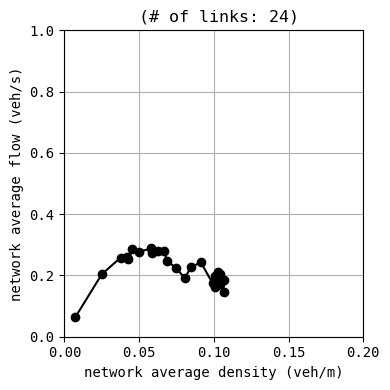

 drawing trajectories in consecutive links...


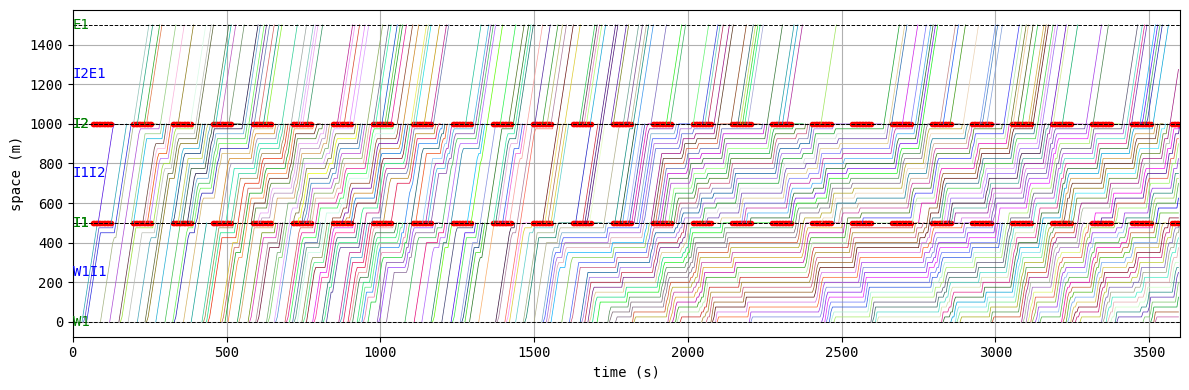

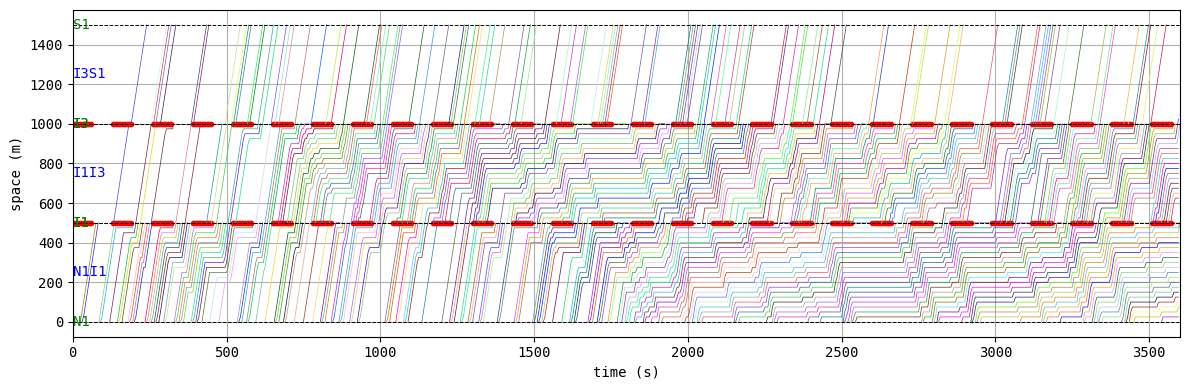

 generating animation...


  0%|          | 0/30 [00:00<?, ?it/s]

In [4]:
# simulation
W.exec_simulation()

# resutls
W.analyzer.print_simple_stats()
W.analyzer.macroscopic_fundamental_diagram()
W.analyzer.time_space_diagram_traj_links([["W1I1", "I1I2", "I2E1"], ["N1I1", "I1I3", "I3S1"]])
W.analyzer.network_anim(detailed=1, network_font_size=0, figsize=(6,6))

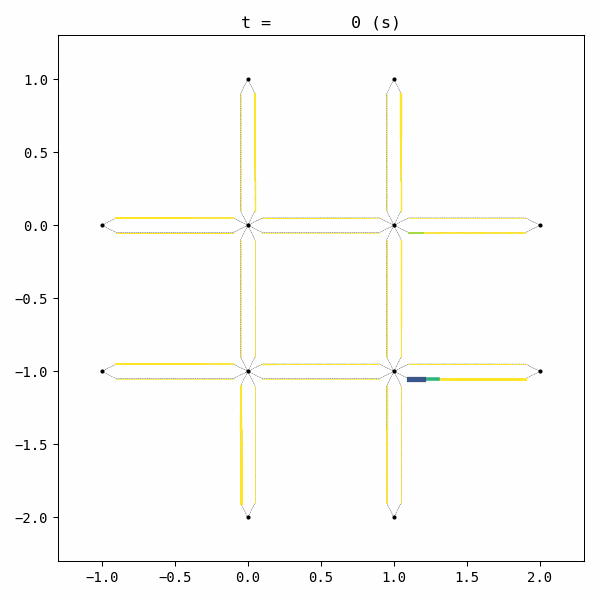

In [5]:
from IPython.display import display, Image
with open("out/anim_network1.gif", "rb") as f:
    display(Image(data=f.read(), format='png'))

Unfortunately, the given demand is slightly larger than the capacity of this network with this signal configuration. As a result, traffic congestion occurs and grows into a gridlock. 

### Deep reinforcement learning by PyTorch

Now we introduce smarter, reactive signal contol by machine learning. We assume that the traffic controller can observe the number of waiting vehicles in each link and determine which direction should be green as each intersection.

We use the [PyTorch](https://pytorch.org/) library, one of the most common deep learning frameworks. Because UXsim is written in pure Python, it is easy to integrate with PyTroch. To do so, we simply modify the [tutorial code of deep reinforcement learning (DRL) by PyTorch](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html). Note that you may need to modify the code slightly depending on your computational environment. 

In this tutorial, we assume that you know the basics of DRL. For the details about DRL and PyTorch, please see the tutorial by PyTorch first.

(Note that this traffic signal control problem with this scale could be solved by much simpler approaches. This example is just a demonstration of how we can integrate UXsim and PyTorch.)

First, import the necessary modules.

In [6]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from scipy.optimize import minimize

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from uxsim import *
import random
import itertools
import copy

### Environment of gymnasium

We define the DRL environment based on `gymnasium` framework. The required functions are: `reset()`: initialization, `step()`: move the time forward. This can be easily defined by integrating UXsim. `reset()` corresponds to simulation scenario definition such as `World()` and `W.addNode()`, and `step()` corresponds to `W.exec_simulation()`. 

We also need to define definition of action, state, and reward, which are the fundamental element of Markov decision process of DRL. `step()` corresponds to transition of Markov decision process.

They are defined as follows.

In [7]:
class TrafficSim(gym.Env):
    def __init__(self):
        """
        traffic scenario: 4 signalized intersections as shown below:
                N1  N2
                |   |
            W1--I1--I2--E1
                |   |
            W2--I3--I4--E2
                |   |
                S1  S2
        Traffic demand is generated from each boundary node to all other boundary nodes.
        action: to determine which direction should have greenlight for every 10 seconds for each intersection. 16 actions.
            action 1: greenlight for I1: direction 0, I2: 0, I3: 0, I4: 0, where direction 0 is E<->W, 1 is N<->S.
            action 2: greenlight for I1: 1, I2: 0, I3: 0, I4: 0
            action 3: greenlight for I1: 0, I2: 1, I3: 0, I4: 0
            action 4: greenlight for I1: 1, I2: 1, I3: 0, I4: 0
            action 5: ...
        state: number of waiting vehicles at each incoming link. 16 dimension.
        reward: negative of difference of total waiting vehicles
        """
        
        #action
        self.n_action = 2**4
        self.action_space = gym.spaces.Discrete(self.n_action) 
        
        #state
        self.n_state = 4*4
        low = np.array([0 for i in range(self.n_state)])
        high = np.array([100 for i in range(self.n_state)])
        self.observation_space = gym.spaces.Box(low=low, high=high)
        
        self.reset()
    
    def reset(self):
        """
        reset the env
        """
        seed = None #whether demand is always random or not
        W = World(
            name="",
            deltan=5,
            tmax=4000,
            print_mode=0, save_mode=0, show_mode=1,
            random_seed=seed,
            duo_update_time=600
        )
        random.seed(seed)

        #network definition
        I1 = W.addNode("I1", 0, 0, signal=[60,60])
        I2 = W.addNode("I2", 1, 0, signal=[60,60])
        I3 = W.addNode("I3", 0, -1, signal=[60,60])
        I4 = W.addNode("I4", 1, -1, signal=[60,60])
        W1 = W.addNode("W1", -1, 0)
        W2 = W.addNode("W2", -1, -1)
        E1 = W.addNode("E1", 2, 0)
        E2 = W.addNode("E2", 2, -1)
        N1 = W.addNode("N1", 0, 1)
        N2 = W.addNode("N2", 1, 1)
        S1 = W.addNode("S1", 0, -2)
        S2 = W.addNode("S2", 1, -2)
        #E <-> W direction: signal group 0
        for n1,n2 in [[W1, I1], [I1, I2], [I2, E1], [W2, I3], [I3, I4], [I4, E2]]:
            W.addLink(n1.name+n2.name, n1, n2, length=500, free_flow_speed=10, jam_density=0.2, signal_group=0)
            W.addLink(n2.name+n1.name, n2, n1, length=500, free_flow_speed=10, jam_density=0.2, signal_group=0)
        #N <-> S direction: signal group 1
        for n1,n2 in [[N1, I1], [I1, I3], [I3, S1], [N2, I2], [I2, I4], [I4, S2]]:
            W.addLink(n1.name+n2.name, n1, n2, length=500, free_flow_speed=10, jam_density=0.2, signal_group=1)
            W.addLink(n2.name+n1.name, n2, n1, length=500, free_flow_speed=10, jam_density=0.2, signal_group=1)

        # random demand definition
        dt = 30
        demand = 0.22
        for n1, n2 in itertools.permutations([W1, W2, E1, E2, N1, N2, S1, S2], 2):
            for t in range(0, 3600, dt):
                W.adddemand(n1, n2, t, t+dt, random.uniform(0, demand))
        
        # store UXsim object for later re-use
        self.W = W
        self.I1 = I1
        self.I2 = I2
        self.I3 = I3
        self.I4 = I4
        self.INLINKS = list(self.I1.inlinks.values()) + list(self.I2.inlinks.values()) + list(self.I3.inlinks.values()) + list(self.I4.inlinks.values())
        
        #initial observation
        observation = np.array([0 for i in range(self.n_state)])
        
        #log
        self.log_state = []
        self.log_reward = []
        
        return observation, None
    
    def comp_state(self):
        """
        compute the current state
        """
        vehicles_per_links = {}
        for l in self.INLINKS:
            vehicles_per_links[l] = l.num_vehicles_queue #l.num_vehicles_queue: the number of vehicles in queue in link l
        return list(vehicles_per_links.values())
    
    def comp_n_veh_queue(self):
        return sum(self.comp_state())
    
    def step(self, action_index):
        """
        proceed env by 1 step = `operation_timestep_width` seconds
        """
        operation_timestep_width = 10
        
        n_queue_veh_old = self.comp_n_veh_queue()
        
        #change signal by action
        #decode action
        binstr = f"{action_index:04b}"
        i1, i2, i3, i4 = int(binstr[3]), int(binstr[2]), int(binstr[1]), int(binstr[0])
        self.I1.signal_phase = i1
        self.I1.signal_t = 0
        self.I2.signal_phase = i2
        self.I2.signal_t = 0
        self.I3.signal_phase = i3
        self.I3.signal_t = 0
        self.I4.signal_phase = i4
        self.I4.signal_t = 0
        
        #traffic dynamics. execute simulation for `operation_timestep_width` seconds
        if self.W.check_simulation_ongoing():
            self.W.exec_simulation(duration_t=operation_timestep_width)
        
        #observe state
        observation = np.array(self.comp_state())
        
        #compute reward
        n_queue_veh = self.comp_n_veh_queue()
        reward = -(n_queue_veh-n_queue_veh_old)
        
        #check termination
        done = False
        if self.W.check_simulation_ongoing() == False:
            done = True
        
        #log
        self.log_state.append(observation)
        self.log_reward.append(reward)
        
        return observation, reward, done, {}, None

### DQN

Then, define the deep Q network (DQN). This is almost identical to the PyTorch tutorial code. Note that the DRL environment `env` is defined using UXsim-based `TrafficSim()`.

In [8]:
env = TrafficSim()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        n_neurals = 64
        n_layers = 3
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(n_observations, n_neurals))
        for i in range(n_layers):
            self.layers.append(nn.Linear(n_neurals, n_neurals))
        self.layer_last = nn.Linear(n_neurals, n_actions)

    # Called with either one element to determine next action, or a batch during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        for layer in self.layers:
            x = F.relu(layer(x))
        return self.layer_last(x)

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row. second column on max result is index of where max element was found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for detailed explanation). This converts batch-array of Transitions to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the columns of actions taken. These are the actions which would've been taken for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

# (hyper)parameters

# the number of transitions sampled from the replay buffer
BATCH_SIZE = 128
# the discount factor as mentioned in the previous section
GAMMA = 0.99
# the starting value of epsilon
EPS_START = 0.9
# the final value of epsilon
EPS_END = 0.05
# the rate of exponential decay of epsilon, higher means a slower decay
EPS_DECAY = 1000
# the update rate of the target network
TAU = 0.005
# the learning rate of the ``AdamW`` optimizer
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

### Execution of DRL

The controller is trained for 200 episodes. For every 50 episodes, the traffic situation is visualized in order to check the training process. Furthermore, the average delay of each episode is printed.

To be fair, the learning process is little bit unstable, so you may need to run it several times to get good results. I executed this code 5 times and obtained 4 successful results. Improving this code to ensure good results is left as an exercise for the reader :)

0:[ 229.416] current best episode!
results:
 average speed:	 1.5 m/s
 number of completed trips:	 2655 / 8295
 average travel time of trips:	 382.4 s
 average delay of trips:	 229.4 s
 delay ratio:			 0.600


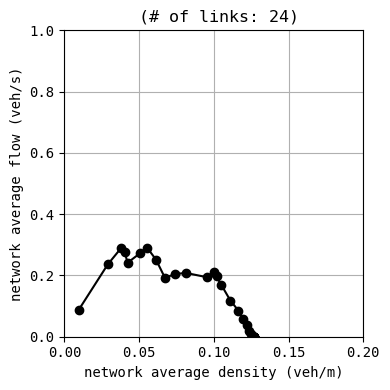

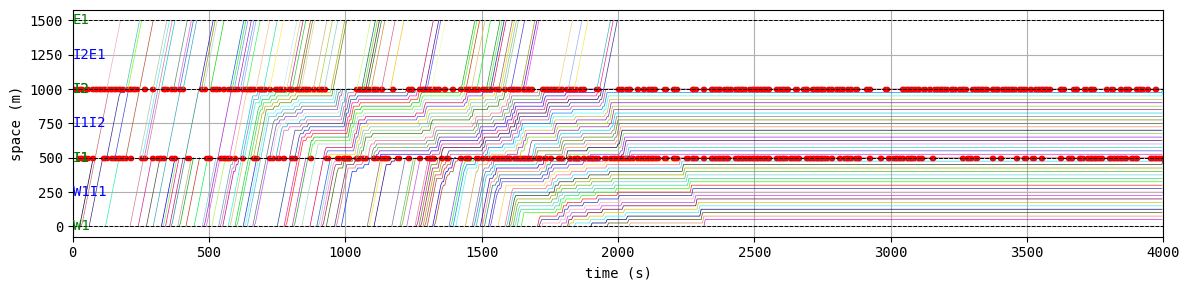

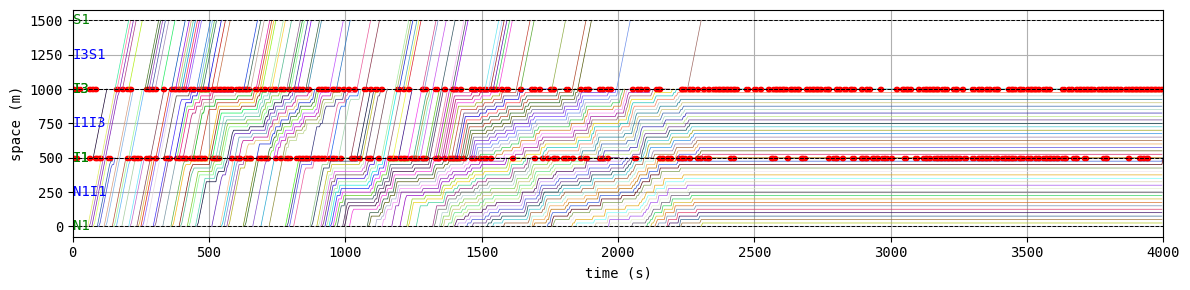

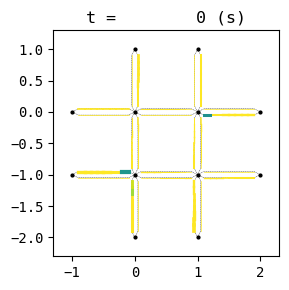

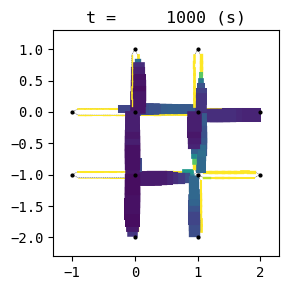

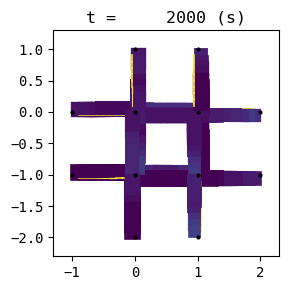

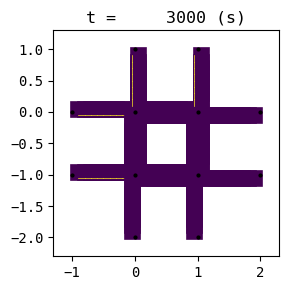

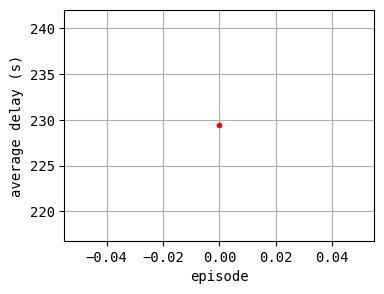

1:[ 321.192] 2:[ 399.226] 3:[ 463.762] 4:[ 226.371] current best episode!
5:[ 640.917] 6:[ 270.411] 7:[ 380.945] 8:[ 441.619] 9:[ 310.518] 10:[ 230.343] 11:[ 138.573] current best episode!
12:[ 433.913] 13:[ 484.298] 14:[ 312.555] 15:[ 507.279] 16:[ 558.807] 17:[ 698.159] 18:[ 239.119] 19:[ 344.510] 20:[ 245.878] 21:[ 434.828] 22:[ 468.006] 23:[ 448.729] 24:[ 635.804] 25:[ 168.455] 26:[ 285.844] 27:[ 277.039] 28:[ 377.585] 29:[ 315.700] 30:[ 489.282] 31:[ 433.727] 32:[ 580.195] 33:[ 652.192] 34:[ 393.517] 35:[ 653.937] 36:[ 556.771] 37:[ 423.003] 38:[ 590.526] 39:[ 165.611] 40:[ 653.259] 41:[ 294.972] 42:[ 490.056] 43:[ 366.773] 44:[ 374.215] 45:[ 186.350] 46:[ 335.516] 47:[ 224.415] 48:[ 135.710] current best episode!
49:[ 92.183] current best episode!
50:[ 114.192] results:
 average speed:	 5.4 m/s
 number of completed trips:	 7360 / 8170
 average travel time of trips:	 269.6 s
 average delay of trips:	 114.2 s
 delay ratio:			 0.424


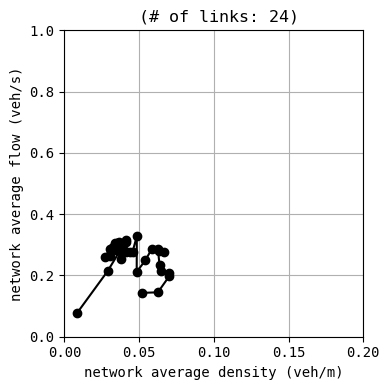

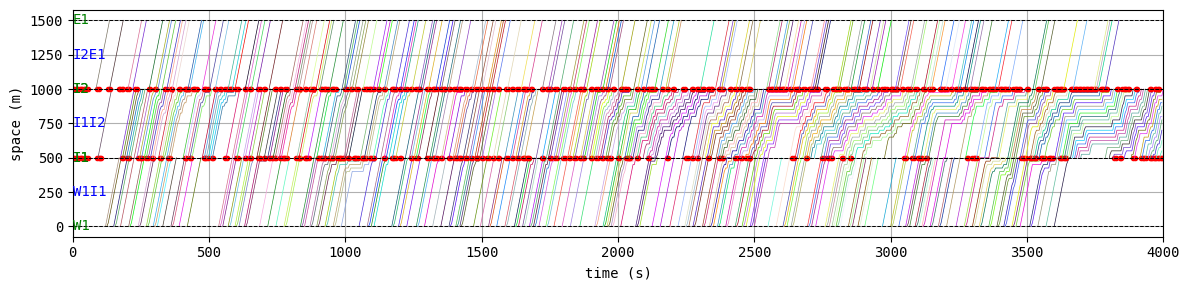

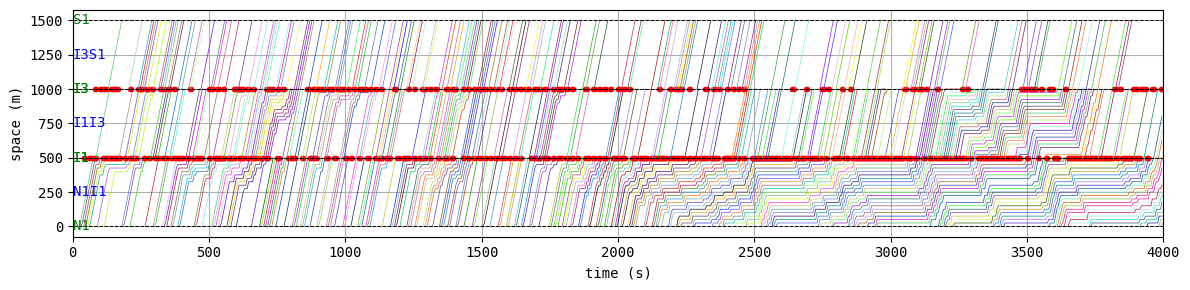

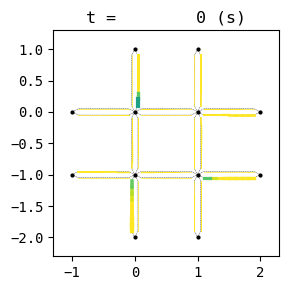

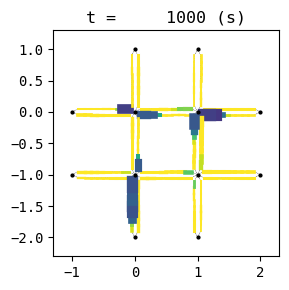

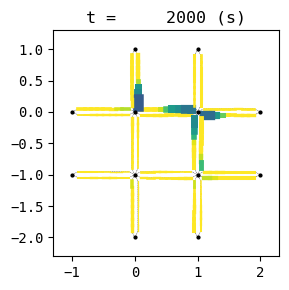

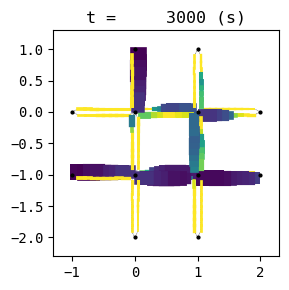

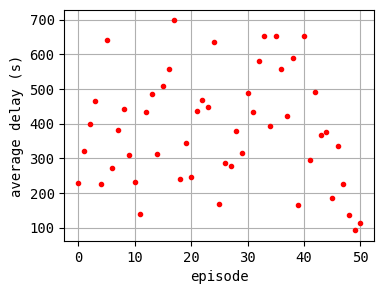

51:[ 277.590] 52:[ 150.782] 53:[ 257.613] 54:[ 212.612] 55:[ 224.935] 56:[ 184.830] 57:[ 95.358] 58:[ 193.474] 59:[ 203.167] 60:[ 231.416] 61:[ 186.775] 62:[ 293.097] 63:[ 131.720] 64:[ 179.769] 65:[ 118.895] 66:[ 73.335] current best episode!
67:[ 150.619] 68:[ 342.907] 69:[ 158.699] 70:[ 103.484] 71:[ 210.011] 72:[ 125.916] 73:[ 203.395] 74:[ 96.551] 75:[ 246.045] 76:[ 40.757] current best episode!
77:[ 73.004] 78:[ 262.548] 79:[ 230.567] 80:[ 177.785] 81:[ 91.219] 82:[ 55.958] 83:[ 201.098] 84:[ 161.981] 85:[ 385.279] 86:[ 227.656] 87:[ 174.673] 88:[ 179.118] 89:[ 52.619] 90:[ 43.493] 91:[ 52.392] 92:[ 678.107] 93:[ 39.798] current best episode!
94:[ 67.321] 95:[ 76.715] 96:[ 40.072] 97:[ 68.669] 98:[ 30.684] current best episode!
99:[ 43.683] 100:[ 40.313] results:
 average speed:	 7.9 m/s
 number of completed trips:	 8215 / 8215
 average travel time of trips:	 197.2 s
 average delay of trips:	 40.3 s
 delay ratio:			 0.204


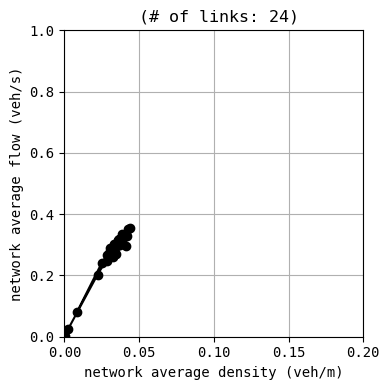

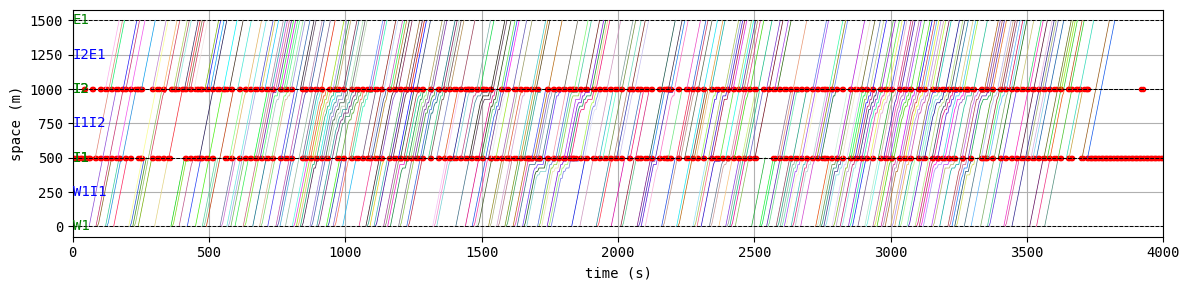

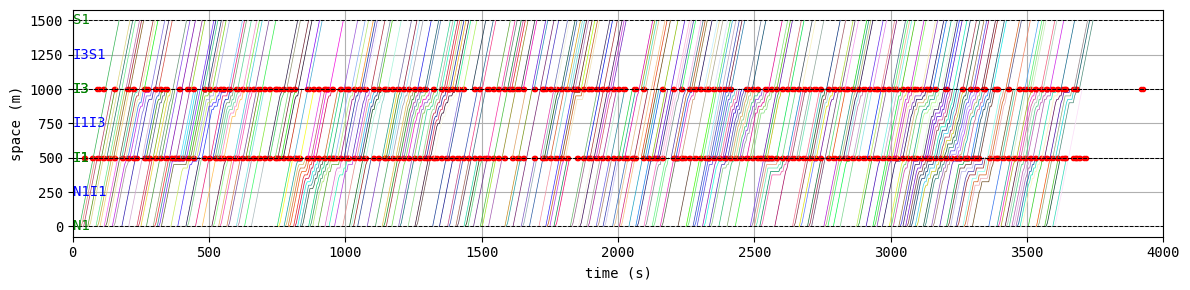

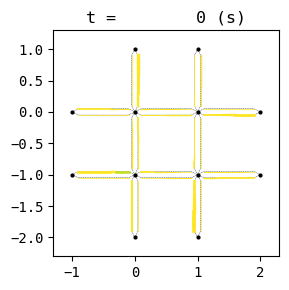

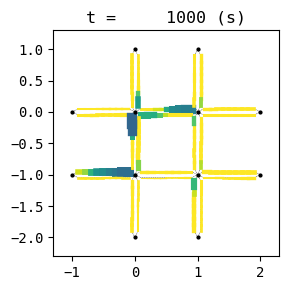

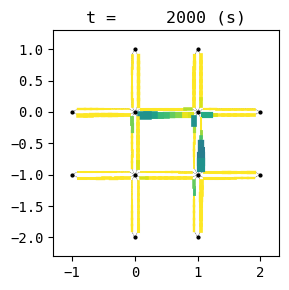

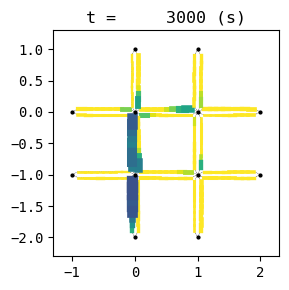

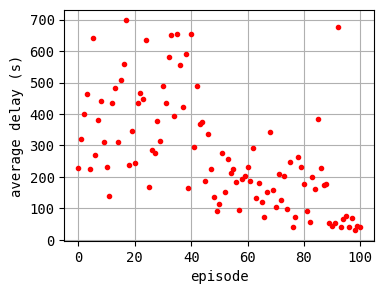

101:[ 31.944] 102:[ 114.854] 103:[ 230.778] 104:[ 49.817] 105:[ 108.831] 106:[ 98.038] 107:[ 224.581] 108:[ 38.929] 109:[ 72.501] 110:[ 50.460] 111:[ 34.152] 112:[ 158.399] 113:[ 246.851] 114:[ 30.243] current best episode!
115:[ 51.990] 116:[ 34.302] 117:[ 32.245] 118:[ 76.308] 119:[ 34.732] 120:[ 40.349] 121:[ 69.287] 122:[ 224.076] 123:[ 31.667] 124:[ 37.446] 125:[ 36.586] 126:[ 51.987] 127:[ 39.085] 128:[ 50.034] 129:[ 104.717] 130:[ 61.916] 131:[ 42.989] 132:[ 43.175] 133:[ 40.565] 134:[ 67.522] 135:[ 171.573] 136:[ 30.075] current best episode!
137:[ 84.652] 138:[ 30.473] 139:[ 139.333] 140:[ 67.611] 141:[ 33.988] 142:[ 29.802] current best episode!
143:[ 84.100] 144:[ 41.850] 145:[ 112.923] 146:[ 83.836] 147:[ 74.280] 148:[ 33.826] 149:[ 28.851] current best episode!
150:[ 439.418] results:
 average speed:	 2.5 m/s
 number of completed trips:	 5240 / 8405
 average travel time of trips:	 594.8 s
 average delay of trips:	 439.4 s
 delay ratio:			 0.739


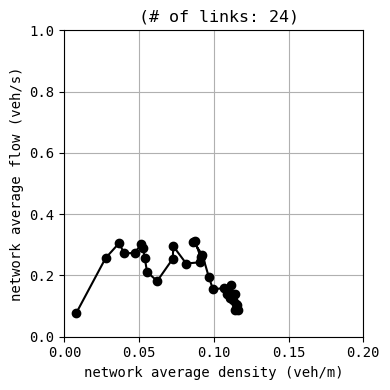

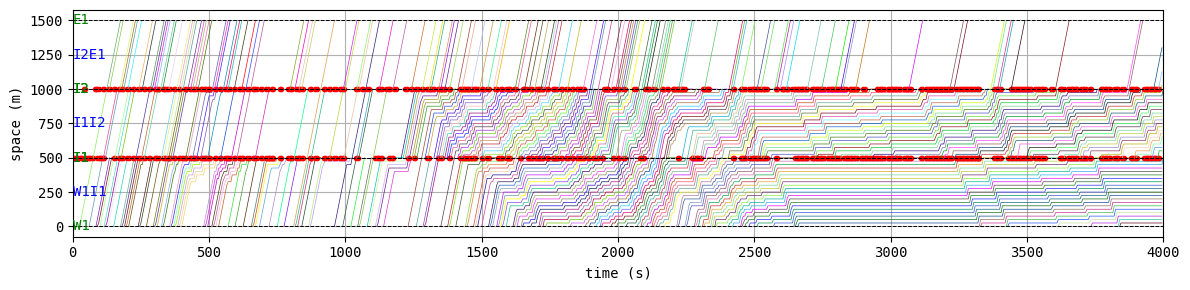

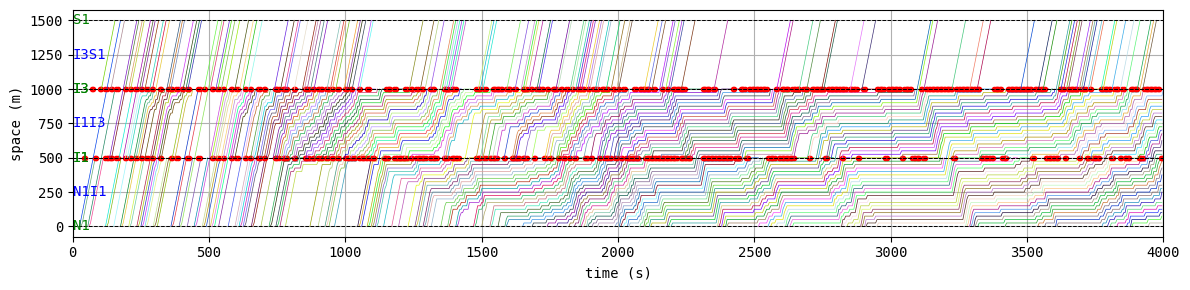

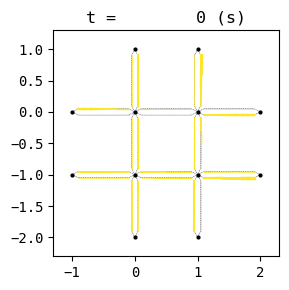

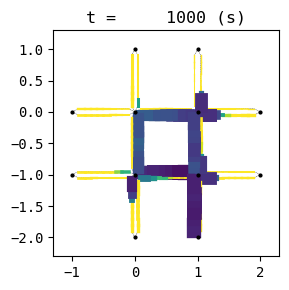

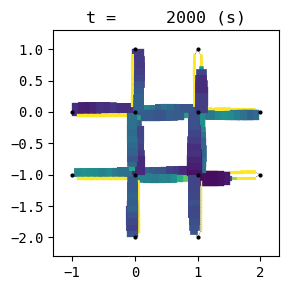

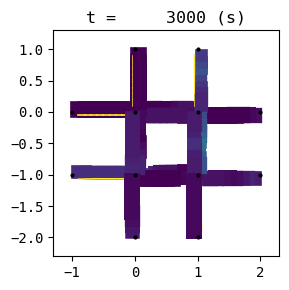

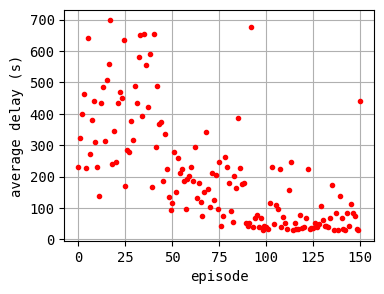

151:[ 48.778] 152:[ 50.863] 153:[ 30.607] 154:[ 26.533] current best episode!
155:[ 48.608] 156:[ 76.405] 157:[ 45.105] 158:[ 176.707] 159:[ 44.435] 160:[ 29.295] 161:[ 44.260] 162:[ 47.457] 163:[ 34.911] 164:[ 56.499] 165:[ 322.188] 166:[ 27.576] 167:[ 34.163] 168:[ 32.765] 169:[ 30.755] 170:[ 26.297] current best episode!
171:[ 237.137] 172:[ 45.472] 173:[ 46.648] 174:[ 37.633] 175:[ 33.835] 176:[ 241.668] 177:[ 27.626] 178:[ 35.069] 179:[ 117.701] 180:[ 247.570] 181:[ 36.962] 182:[ 51.435] 183:[ 49.493] 184:[ 41.615] 185:[ 30.162] 186:[ 34.552] 187:[ 53.522] 188:[ 36.198] 189:[ 69.100] 190:[ 41.172] 191:[ 143.601] 192:[ 29.430] 193:[ 66.802] 194:[ 29.787] 195:[ 40.746] 196:[ 80.865] 197:[ 37.015] 198:[ 25.655] current best episode!
199:[ 62.897] results:
 average speed:	 7.2 m/s
 number of completed trips:	 8145 / 8145
 average travel time of trips:	 220.4 s
 average delay of trips:	 62.9 s
 delay ratio:			 0.285


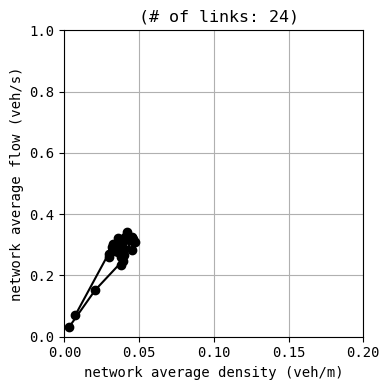

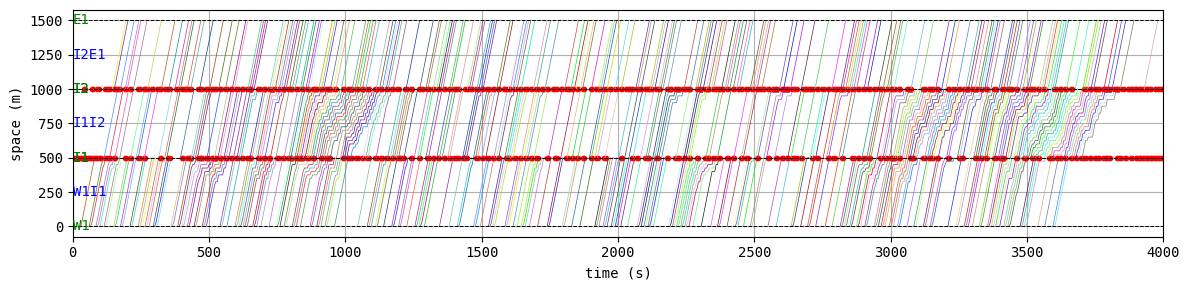

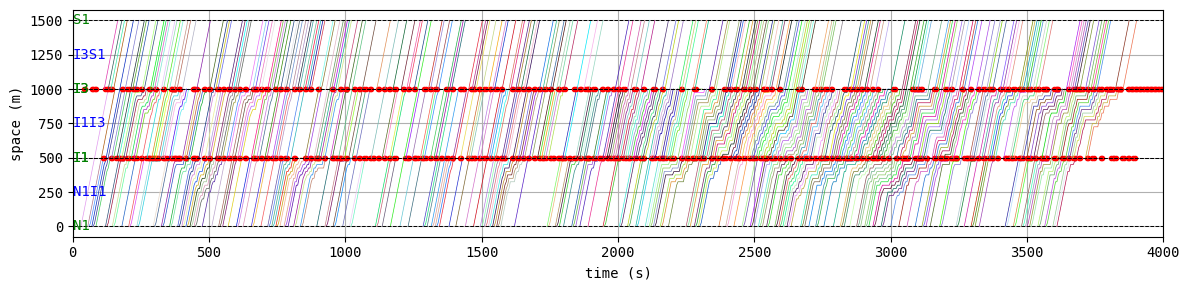

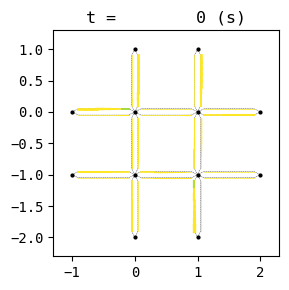

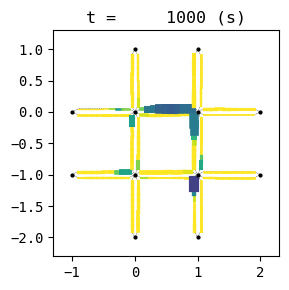

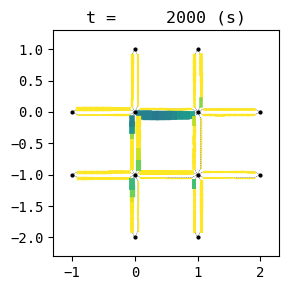

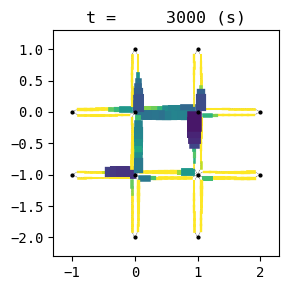

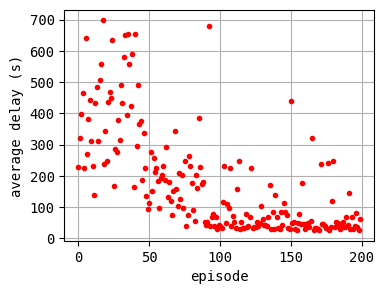

In [9]:
num_episodes = 200

log_states = []
log_epi_average_delay = []
best_average_delay = 9999999999999999999999999
best_W = None
best_i_episode = -1
for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    log_states.append([])
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        log_states[-1].append(state)
        
        # Store the transition in memory
        memory.push(state, action, next_state, reward)
        
        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            log_epi_average_delay.append(env.W.analyzer.average_delay)
            print(f"{i_episode}:[{env.W.analyzer.average_delay : .3f}]", end=" ")
            if env.W.analyzer.average_delay < best_average_delay:
                print("current best episode!")
                best_average_delay = env.W.analyzer.average_delay
                best_W = copy.deepcopy(env.W)
                best_i_episode = i_episode
            break
    
    if i_episode%50 == 0 or i_episode == num_episodes-1:
        env.W.analyzer.print_simple_stats(force_print=True)
        env.W.analyzer.macroscopic_fundamental_diagram()
        env.W.analyzer.time_space_diagram_traj_links([["W1I1", "I1I2", "I2E1"], ["N1I1", "I1I3", "I3S1"]], figsize=(12,3))
        for t in list(range(0,env.W.TMAX,int(env.W.TMAX/4))):
            env.W.analyzer.network(t, detailed=1, network_font_size=0, figsize=(3,3))
        
        plt.figure(figsize=(4,3))
        plt.plot(log_epi_average_delay, "r.")
        plt.xlabel("episode")
        plt.ylabel("average delay (s)")
        plt.grid()
        plt.show()

According to the relation between episode and average delay, it is clear that the controller is successfully trained. The average delay under good traffic signal control is about 30 seconds. You can confirm the efficiency of the controller by checking the time-space diagrams and MFD of 199th episode with "without control" case that was shown in the beginning of this notebook.

Let's see the results of the best episode.

BEST EPISODE: 198, with average delay 25.655307994757536
results:
 average speed:	 8.5 m/s
 number of completed trips:	 7630 / 7630
 average travel time of trips:	 182.5 s
 average delay of trips:	 25.7 s
 delay ratio:			 0.141


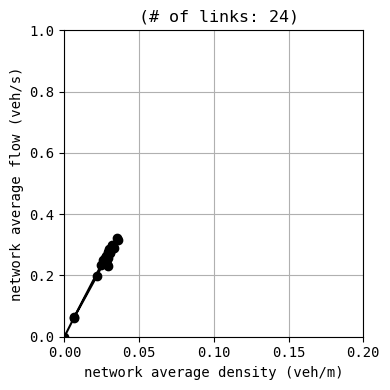

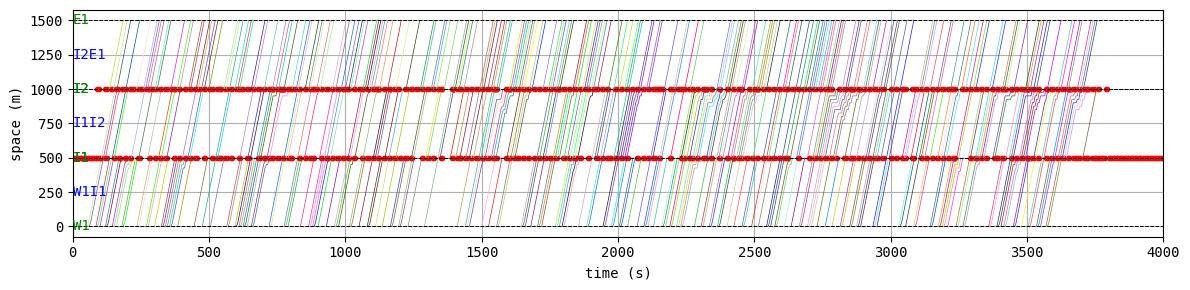

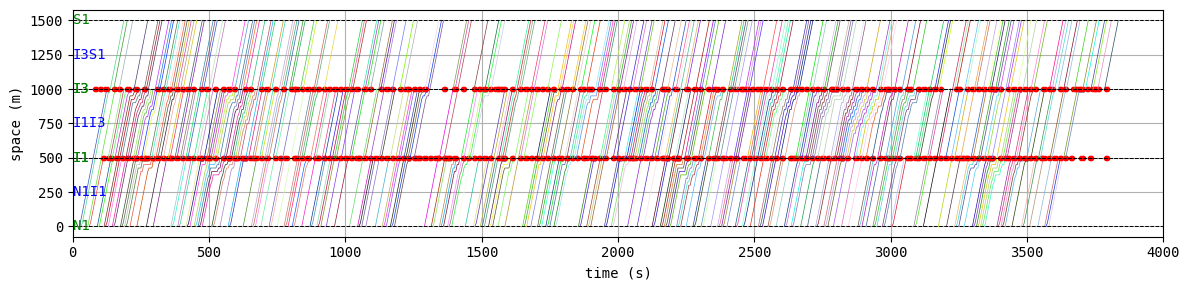

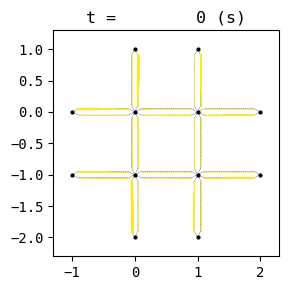

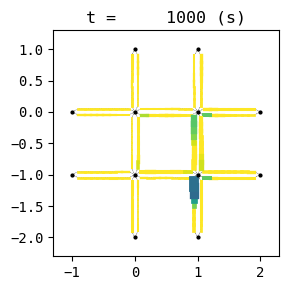

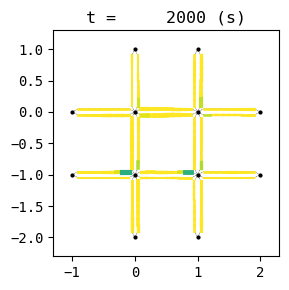

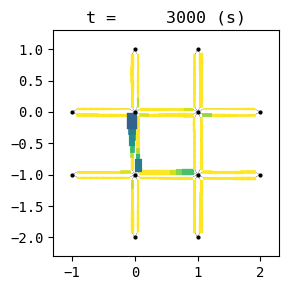

start anim
end anim


In [10]:
print(f"BEST EPISODE: {best_i_episode}, with average delay {best_average_delay}")
best_W.analyzer.print_simple_stats(force_print=True)
best_W.analyzer.macroscopic_fundamental_diagram()
best_W.analyzer.time_space_diagram_traj_links([["W1I1", "I1I2", "I2E1"], ["N1I1", "I1I3", "I3S1"]], figsize=(12,3))
for t in list(range(0,best_W.TMAX,int(env.W.TMAX/4))):
    best_W.analyzer.network(t, detailed=1, network_font_size=0, figsize=(3,3))
best_W.save_mode = 1
print("start anim")
best_W.analyzer.network_anim(detailed=1, network_font_size=0, figsize=(6,6))
print("end anim")

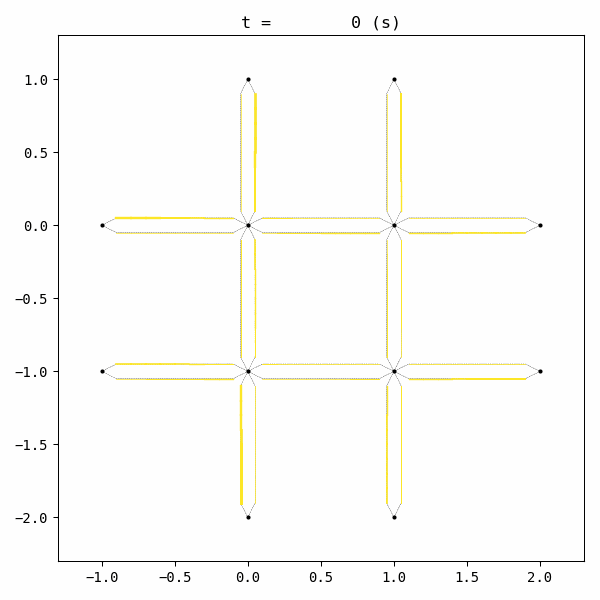

In [11]:
from IPython.display import display, Image
with open("out/anim_network1.gif", "rb") as f:
    display(Image(data=f.read(), format='png'))

By comparing to the animation of without control scenario, we can see that this controller works very well.

### Computation time

The computation time for the training is measured as follows. `../p06_corrdinated_signal_DQN_novisual.py` in the following cell is basically identical to the above code, but without visualization. The computation environment was not very good: Windows 10 Pro, Intel Core i7-9800 (3.8GHz\*16 CPUs), NVIDIA GeForce RTX 2060 with CUDA 12.1, 32GB RAM. 

According to the result, the total training time was about 13 min. The computation time of UXsim itself for 1 simulation in 1 episode was 1-2 seconds (see the first example). Therefore, the most of the computation burden is from training and computation of neural nets. This suggests that UXsim is useful as a simulation environment for DRL.

In [12]:
%%time
%run ../p06_corrdinated_signal_DQN_novisual.py

0:[ 115.092] current best episode!
results:
 average speed:	 5.7 m/s
 number of completed trips:	 8145 / 8285
 average travel time of trips:	 272.1 s
 average delay of trips:	 115.1 s
 delay ratio:			 0.423
1:[ 352.845] 2:[ 250.794] 3:[ 186.335] 4:[ 370.334] 5:[ 508.109] 6:[ 706.412] 7:[ 912.967] 8:[ 348.500] 9:[ 509.087] 10:[ 390.742] 11:[ 276.900] 12:[ 509.192] 13:[ 229.282] 14:[ 489.112] 15:[ 832.331] 16:[ 303.941] 17:[ 162.846] 18:[ 345.606] 19:[ 275.368] 20:[ 336.850] 21:[ 161.022] 22:[ 571.344] 23:[ 664.135] 24:[ 268.285] 25:[ 333.105] 26:[ 209.497] 27:[ 586.245] 28:[ 191.548] 29:[ 497.588] 30:[ 281.568] 31:[ 235.737] 32:[ 116.722] 33:[ 292.343] 34:[ 82.404] current best episode!
35:[ 478.742] 36:[ 323.343] 37:[ 311.965] 38:[ 76.219] current best episode!
39:[ 246.135] 40:[ 483.019] 41:[ 196.218] 42:[ 238.521] 43:[ 246.603] 44:[ 108.926] 45:[ 91.515] 46:[ 399.735] 47:[ 206.325] 48:[ 40.443] current best episode!
49:[ 387.010] 50:[ 140.943] results:
 average speed:	 5.1 m/s
 numbe

<Figure size 640x480 with 0 Axes>